Using TensorFlow backend.
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/t

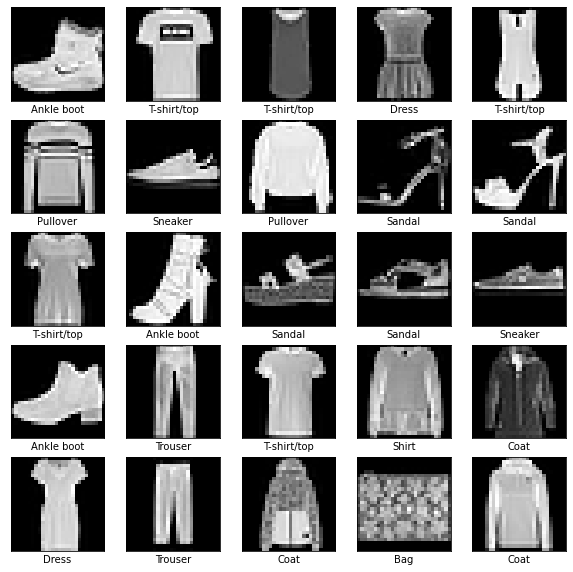

In [1]:
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


x_train = np.array([cv2.cvtColor(train_img, cv2.COLOR_GRAY2RGB) for train_img in x_train])
x_test = np.array([cv2.cvtColor(test_img, cv2.COLOR_GRAY2RGB) for test_img in x_test])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [2]:
from keras.models import load_model

model = load_model('fashion_mnist-rgb.h5')
print(model.summary())



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)            

# LIME EXPLAINER

In [3]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

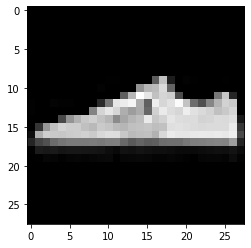

In [4]:
import random

random_idx = random.choice(range(len(x_test)))
to_explain_img = x_test[random_idx]
to_explain_label = y_test[random_idx]

plt.figure()
plt.imshow(to_explain_img)
plt.grid(False)
plt.show()

In [5]:
%%time
explanation = explainer.explain_instance(to_explain_img, 
                                         classifier_fn = model.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100% |########################################################################|


CPU times: user 4.45 s, sys: 1.28 s, total: 5.74 s
Wall time: 3.49 s


Text(0.5, 1.0, 'Positive/Negative Regions for Sneaker')

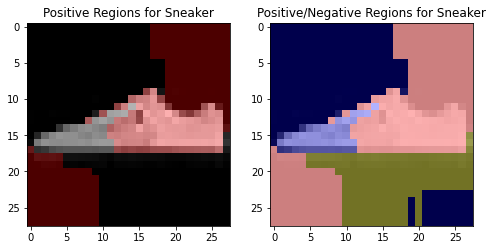

In [6]:
from skimage.color import gray2rgb, rgb2gray, label2rgb

temp, mask = explanation.get_image_and_mask(to_explain_label, positive_only=True, num_features=10, 
                                            hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask, temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(class_names[to_explain_label]))

temp, mask = explanation.get_image_and_mask(to_explain_label, positive_only=False, num_features=10, 
                                            hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(class_names[to_explain_label]))

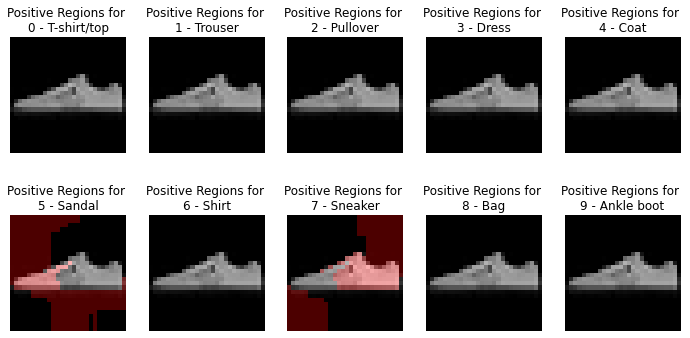

In [7]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, 
                                                hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask, to_explain_img, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title(f'Positive Regions for \n{i} - {class_names[i]}')
    c_ax.axis('off')